# This file creates sliders for the system that extend those in playground3.ipynb.
## These sliders also have sliders for the bandgap.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
from ipywidgets import interact, FloatSlider, fixed

# Add the directory containing ff.py to the Python path
# Assuming ff.py is in the trials directory
trials_dir = os.path.join(os.path.dirname(os.getcwd()), 'trials')
if trials_dir not in sys.path:
    sys.path.append(trials_dir)

# Import the power_ratio function from ff.py
try:
    import ff
    print("Successfully imported ff module")
except ImportError:
    print("Could not import ff module. Please check the path.")
    
    # Define a fallback power_ratio function in case import fails
    def power_ratio(wavelengths, emissivity, T_e, bandgap_ev):
        # Convert bandgap from eV to wavelength in microns
        bandgap_wl = 1.24 / bandgap_ev
        bandgap_idx = np.argmin(np.abs(wavelengths - bandgap_wl))
        
        # Calculate blackbody radiation
        h = 6.626070e-34  # Js Planck's constant
        c = 2.997925e8    # m/s speed of light
        k_B = 1.380649e-23  # J/K Boltzmann constant
        
        # Convert wavelengths to meters for calculation
        wl_m = wavelengths * 1e-6
        
        # Calculate spectral radiance (W/m²/m)
        bb_spectral = (2*h*c**2) / ((np.exp((h*c)/(k_B*T_e*wl_m))-1) * wl_m**5)
        
        # Multiply by emissivity to get spectral power density
        spectral_power = emissivity * bb_spectral
        
        # Calculate power ratio
        power_below_bandgap = np.trapz(spectral_power[:bandgap_idx], wavelengths[:bandgap_idx])
        power_total = np.trapz(spectral_power, wavelengths)
        
        return power_below_bandgap / power_total if power_total > 0 else 0

# Path to your log directory - update this to your actual log path
# log_dir = '../logs/def-eb619965_6'
log_dir = '../tracked-logs/def-887bc81e_1'

# Get all emissivity files
emissivity_files = glob.glob(os.path.join(log_dir, 'emissivity_*.txt'))
print(f"Found {len(emissivity_files)} emissivity files")

# Extract parameters from filenames
params_list = []
for file_path in emissivity_files:
    filename = os.path.basename(file_path)
    # Parse parameters from filename: emissivity_{block_height}H_{block_width}W_{aln_thickness}AlN.txt
    parts = filename.replace('emissivity_', '').replace('.txt', '').split('_')
    
    block_height = float(parts[0].replace('H', ''))
    block_width = float(parts[1].replace('W', ''))
    aln_thickness = float(parts[2].replace('AlN', ''))
    
    params_list.append({
        'block_height': block_height,
        'block_width': block_width,
        'aln_thickness': aln_thickness,
        'file_path': file_path
    })

# Get unique values for each parameter
block_heights = sorted(list(set([p['block_height'] for p in params_list])))
block_widths = sorted(list(set([p['block_width'] for p in params_list])))
aln_thicknesses = sorted(list(set([p['aln_thickness'] for p in params_list])))

print(f"Block heights: {block_heights}")
print(f"Block widths: {block_widths}")
print(f"AlN thicknesses: {aln_thicknesses}")

# Load wavelengths from the simulation parameters
wavelengths = np.linspace(.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]  # Remove problematic wavelengths

# Determine global axis limits by examining all emissivity data
all_emissivity_data = []
for p in params_list:
    emissivity = np.loadtxt(p['file_path'])
    all_emissivity_data.append(emissivity)

# Calculate global min and max for consistent y-axis
global_min = min(np.min(data) for data in all_emissivity_data)
global_max = max(np.max(data) for data in all_emissivity_data)

# Add a small margin to the limits
y_margin = 0.05 * (global_max - global_min)
global_y_min = max(0, global_min - y_margin)  # Ensure we don't go below 0 for emissivity
global_y_max = global_max + y_margin

# Function to find the closest value in a list
def find_closest(value, options):
    return min(options, key=lambda x: abs(x - value))

# Function to plot emissivity for given parameters
def plot_emissivity(block_height, block_width, bandgap_ev, aln_thickness, compare=False):
    # Find closest parameter values in our dataset
    h = find_closest(block_height, block_heights)
    w = find_closest(block_width, block_widths)
    t = find_closest(aln_thickness, aln_thicknesses)
    
    # Find the matching file
    matching_params = [p for p in params_list 
                      if abs(p['block_height'] - h) < 1e-5 
                      and abs(p['block_width'] - w) < 1e-5 
                      and abs(p['aln_thickness'] - t) < 1e-5]
    
    if not matching_params:
        print(f"No data found for parameters close to: height={h}, width={w}, thickness={t}")
        return
    
    file_path = matching_params[0]['file_path']
    emissivity = np.loadtxt(file_path)
    
    # Convert to torch tensor if ff.power_ratio expects torch tensors
    try:
        import torch
        emissivity_tensor = torch.tensor(emissivity)
        wavelengths_tensor = torch.tensor(wavelengths)
    except ImportError:
        emissivity_tensor = emissivity
        wavelengths_tensor = wavelengths
    
    plt.figure(figsize=(12, 6))
    
    # Plot emissivity vs wavelength
    plt.subplot(1, 2, 1)
    plt.plot(wavelengths, emissivity, 'b-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Emissivity')
    plt.title(f'Emissivity Profile\nH={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
    plt.grid(True, alpha=0.3)
    
    # Set consistent y-axis limits
    plt.ylim(global_y_min, global_y_max)
    
    # Add vertical line at bandgap wavelength (0.726 eV = ~1.71 μm)
    # bandgap_ev = 0.726
    bandgap_wl = 1.24 / bandgap_ev
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
    
    # Highlight regions (below and above bandgap)
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Desired emission')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Undesired emission')
    plt.legend()
    
    # Plot spectral power density (emissivity * blackbody)
    plt.subplot(1, 2, 2)
    
    # Calculate blackbody radiation at T_e = 2073.15K (from your code)
    h_const = 6.626070e-34  # Js Planck's constant
    c_const = 2.997925e8    # m/s speed of light
    k_B = 1.380649e-23  # J/K Boltzmann constant
    T_e = 2073.15     # K emitter temperature
    
    # Convert wavelengths to meters for calculation
    wl_m = wavelengths * 1e-6
    
    # Calculate spectral radiance (W/m²/m)
    bb_spectral = (2*h_const*c_const**2) / ((np.exp((h_const*c_const)/(k_B*T_e*wl_m))-1) * wl_m**5)
    
    # Multiply by emissivity to get spectral power density
    spectral_power = emissivity * bb_spectral
    
    # Normalize for better visualization
    spectral_power = spectral_power / np.max(spectral_power)
    
    plt.plot(wavelengths, spectral_power, 'g-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Normalized Spectral Power')
    plt.title('Spectral Power Density (Emissivity × Blackbody)')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)  # Consistent y-axis for normalized power
    
    # Add vertical line at bandgap wavelength
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
    
    # Highlight regions
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Useful power')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Wasted power')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display FOM using the actual power_ratio function
    import sys
    sys.path.append('../trials')
    import ff
    import torch
    fom = ff.power_ratio(torch.tensor(wavelengths), torch.tensor(emissivity), ff.T_e, bandgap_ev)#.726
    
    print(f"Figure of Merit (power ratio): {fom:.4f}")
    
    if compare:
        # Compare with other configurations
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the current configuration
        ax.plot(wavelengths, emissivity, 'b-', linewidth=2, 
                label=f'H={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
        
        # Plot a few other configurations for comparison
        colors = ['r', 'g', 'm', 'c', 'y']
        color_idx = 0
        
        # Get some different configurations to compare
        other_params = [p for p in params_list 
                       if not (abs(p['block_height'] - h) < 1e-5 
                              and abs(p['block_width'] - w) < 1e-5 
                              and abs(p['aln_thickness'] - t) < 1e-5)]
        
        # Select a few different configurations (max 5)
        compare_params = other_params[:5] if len(other_params) > 5 else other_params
        
        for p in compare_params:
            other_emissivity = np.loadtxt(p['file_path'])
            ax.plot(wavelengths, other_emissivity, 
                   color=colors[color_idx], linestyle='--', 
                   label=f"H={p['block_height']:.3f}μm, W={p['block_width']:.3f}μm, AlN={p['aln_thickness']:.3f}μm")
            color_idx = (color_idx + 1) % len(colors)
        
        ax.set_xlabel('Wavelength (μm)')
        ax.set_ylabel('Emissivity')
        ax.set_title('Comparison of Different Configurations')
        ax.axvline(x=bandgap_wl, color='k', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
        ax.grid(True, alpha=0.3)
        
        # Set consistent y-axis limits for comparison plot
        ax.set_ylim(global_y_min, global_y_max)
        
        # Add shaded regions for below/above bandgap
        ax.axvspan(wavelengths[0], bandgap_wl, alpha=0.1, color='green')
        ax.axvspan(bandgap_wl, wavelengths[-1], alpha=0.1, color='red')
        
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        # Also show a comparison of the spectral power densities
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Calculate and plot spectral power for current configuration
        spectral_power = emissivity * bb_spectral
        normalized_power = spectral_power / np.max(spectral_power)
        ax.plot(wavelengths, normalized_power, 'b-', linewidth=2, 
                label=f'H={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
        
        # Calculate and plot spectral power for comparison configurations
        color_idx = 0
        for p in compare_params:
            other_emissivity = np.loadtxt(p['file_path'])
            other_spectral_power = other_emissivity * bb_spectral
            other_normalized_power = other_spectral_power / np.max(other_spectral_power)
            ax.plot(wavelengths, other_normalized_power, 
                   color=colors[color_idx], linestyle='--', 
                   label=f"H={p['block_height']:.3f}μm, W={p['block_width']:.3f}μm, AlN={p['aln_thickness']:.3f}μm")
            color_idx = (color_idx + 1) % len(colors)
        
        ax.set_xlabel('Wavelength (μm)')
        ax.set_ylabel('Normalized Spectral Power')
        ax.set_title('Comparison of Different Configurations')
        plt.axvline(x=bandgap_wl, color='k', linestyle='--', label='Bandgap (0.726 eV)')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

# Create interactive widget
interact(
    plot_emissivity,
    block_height=FloatSlider(min=min(block_heights), max=max(block_heights), 
                            step=(max(block_heights)-min(block_heights))/len(block_heights), 
                            value=block_heights[len(block_heights)//2]),
    block_width=FloatSlider(min=min(block_widths), max=max(block_widths), 
                           step=(max(block_widths)-min(block_widths))/len(block_widths), 
                           value=block_widths[len(block_widths)//2]),
    aln_thickness=FloatSlider(min=min(aln_thicknesses), max=max(aln_thicknesses), 
                             step=(max(aln_thicknesses)-min(aln_thicknesses))/len(aln_thicknesses), 
                             value=aln_thicknesses[len(aln_thicknesses)//2]),
    bandgap_ev=FloatSlider(min=0.41, max=1.5, step=0.01, value=0.726),
    compare=True
)




Successfully imported ff module
Found 120 emissivity files
Block heights: [0.05, 0.175, 0.3, 0.425, 0.55]
Block widths: [0.01, 0.05, 0.2, 0.45]
AlN thicknesses: [0.01, 0.1, 0.35, 0.473, 0.55, 0.85]


interactive(children=(FloatSlider(value=0.3, description='block_height', max=0.55, min=0.05), FloatSlider(valu…

<function __main__.plot_emissivity(block_height, block_width, bandgap_ev, aln_thickness, compare=False)>

In [88]:
# Define the data as a multiline string
data = """
0.3499999940395355: 0.7017243404180289
0.3700000047683716: 0.791185171174622
0.38999998569488525: 0.9665064794742416
0.4099999964237213: 0.7821489297374047
0.4300000071525574: 0.7980490991003693
0.44999998807907104: 0.8902798373825878
0.4699999988079071: 0.9733104321966068
0.49000000953674316: 0.9100816309788626
0.5099999904632568: 0.8711296998798976
0.5300000309944153: 0.8697776027771436
0.550000011920929: 0.9284913451575281
0.5699999928474426: 0.9401922706893068
0.5900000333786011: 0.9680055155537319
0.6100000143051147: 0.9731489952962618
0.6299999952316284: 0.9451032835750328
0.6500000357627869: 0.9483071440544004
0.6700000166893005: 0.9599671081493285
0.6899999976158142: 0.9448480984556787
0.7100000381469727: 0.9257136176305275
0.7300000190734863: 0.9240256184225815
0.75: 0.9424389736375266
0.7700000405311584: 0.9633747653832757
0.7900000214576721: 0.9849709231588987
0.8100000023841858: 0.9807694028820527
0.8300000429153442: 0.9763693943806454
0.8500000238418579: 0.9785207722956744
0.8700000047683716: 0.9811700131097119
0.89000004529953: 0.9707849495826871
0.9100000262260437: 0.948459759526376
0.9300000071525574: 0.9252570866306699
0.9500000476837158: 0.9096982160642537
0.9700000286102295: 0.9108441237408236
0.9900000095367432: 0.9252133836845948
1.0099999904632568: 0.9333952624012356
1.0299999713897705: 0.9375403483933168
1.0500000715255737: 0.9310615778564607
1.0700000524520874: 0.918219171491699
1.090000033378601: 0.9073375864306347
1.1100000143051147: 0.8964264701850233
1.1299999952316284: 0.8779859001452917
1.149999976158142: 0.8691524343096487
1.1700000762939453: 0.8712810135639896
1.190000057220459: 0.8792536116905045
1.2100000381469727: 0.886764298231321
1.2300000190734863: 0.8954089654067741
1.25: 0.9079901146238963
1.2699999809265137: 0.9238948537438522
1.290000081062317: 0.9401886372704483
1.3100000619888306: 0.9544595781822303
1.3300000429153442: 0.9641511874412081
1.350000023841858: 0.9685788721446713
1.3700000047683716: 0.9684327933324471
1.3899999856948853: 0.9632483861401115
1.4100000858306885: 0.954688407195503
1.4300000667572021: 0.9581672856860384
1.4500000476837158: 0.9601982085806512
1.4700000286102295: 0.9590526325165574
1.4900000095367432: 0.9567151207218467
1.5099999904632568: 0.9550482131375404
1.53000009059906: 0.9543932171206672
1.5500000715255737: 0.9527062934726593
1.5700000524520874: 0.9496089356218697
1.590000033378601: 0.9434534778796189
1.6100000143051147: 0.9330312323318476
1.630000114440918: 0.9179353393674894
1.6500000953674316: 0.8975176344988235
1.6700000762939453: 0.8716321991844245
1.6899999380111694: 0.8404118892313029
1.709999918937683: 0.8046916224930656
1.7299998998641968: 0.7647659600901335
1.75: 0.71894011329918
1.7699999809265137: 0.6645300949232585
1.7899999618530273: 0.6058566681201711
1.809999942779541: 0.5731302063579556
1.8299999237060547: 0.6010300507813555
1.8499999046325684: 0.6323947072186175
1.8700000047683716: 0.6332788008006645
1.8899999856948853: 0.6163135131552846
1.909999966621399: 0.5918309394403858
1.9299999475479126: 0.5638868435964319
1.9499999284744263: 0.5338838272846977
1.96999990940094: 0.5023456695319617
1.9900000095367432: 0.4698475469939424
2.009999990463257: 0.4369282276728722
2.0299999713897705: 0.404872540259393
2.049999952316284: 0.3753579066562255
2.069999933242798: 0.3494614898610504
2.0899999141693115: 0.32855211388334316
2.109999895095825: 0.3113417137032344
2.129999876022339: 0.2973205281693805
2.1499998569488525: 0.2874514523590901
2.1700000762939453: 0.2807692009080949
2.190000057220459: 0.276306381896106
2.2100000381469727: 0.2747530768694324
2.2300000190734863: 0.27824100920513106
2.25: 0.28287376470147685
2.2699999809265137: 0.27764077787123664
2.2899999618530273: 0.2701872797229641
2.309999942779541: 0.2659172970896061
2.3299999237060547: 0.26351945872307414
2.3499999046325684: 0.26186109899389043
2.369999885559082: 0.2605953159306257
2.3899998664855957: 0.2597925478913041
2.4100000858306885: 0.25967063404005897
2.430000066757202: 0.2596302885476557
2.450000047683716: 0.2596758705314879
2.4700000286102295: 0.25982539287493667
2.490000009536743: 0.26057244233385435
2.509999990463257: 0.26192260258805156
2.5299999713897705: 0.2634817629825421
2.549999952316284: 0.2652870199300519
2.569999933242798: 0.2673766533799773
2.5899999141693115: 0.2695276597081443
2.609999895095825: 0.2714564647537614
2.629999876022339: 0.2736290992502163
2.6500000953674316: 0.2760738779667936
2.6700000762939453: 0.2788214144276868
2.690000057220459: 0.2818984778684748
2.7100000381469727: 0.284678169708675
2.7300000190734863: 0.28759767185559193
2.75: 0.29089966255951594
2.7699999809265137: 0.2946009959019751
2.7899999618530273: 0.2987135546397912
2.809999942779541: 0.30324761164208747
2.8299999237060547: 0.3076255724844472
2.8499999046325684: 0.3120657039617919
2.869999885559082: 0.31694144467730667
2.890000104904175: 0.3222502862290686
2.9100000858306885: 0.327990695966323
2.930000066757202: 0.3341592501456655
2.950000047683716: 0.34074567091739827
2.9700000286102295: 0.3474849985221722
2.990000009536743: 0.3547174113490196
"""

# Parse the data into a dictionary with rounded keys
pairs = {}
for line in data.strip().splitlines():
    if line.strip():  # Skip empty lines if any
        key_str, value_str = line.split(':')
        key = float(key_str.strip())
        value = float(value_str.strip())
        rounded_key = round(key, 2)
        pairs[rounded_key] = value

# Display the resulting dictionary
print(pairs)


{0.35: 0.7017243404180289, 0.37: 0.791185171174622, 0.39: 0.9665064794742416, 0.41: 0.7821489297374047, 0.43: 0.7980490991003693, 0.45: 0.8902798373825878, 0.47: 0.9733104321966068, 0.49: 0.9100816309788626, 0.51: 0.8711296998798976, 0.53: 0.8697776027771436, 0.55: 0.9284913451575281, 0.57: 0.9401922706893068, 0.59: 0.9680055155537319, 0.61: 0.9731489952962618, 0.63: 0.9451032835750328, 0.65: 0.9483071440544004, 0.67: 0.9599671081493285, 0.69: 0.9448480984556787, 0.71: 0.9257136176305275, 0.73: 0.9240256184225815, 0.75: 0.9424389736375266, 0.77: 0.9633747653832757, 0.79: 0.9849709231588987, 0.81: 0.9807694028820527, 0.83: 0.9763693943806454, 0.85: 0.9785207722956744, 0.87: 0.9811700131097119, 0.89: 0.9707849495826871, 0.91: 0.948459759526376, 0.93: 0.9252570866306699, 0.95: 0.9096982160642537, 0.97: 0.9108441237408236, 0.99: 0.9252133836845948, 1.01: 0.9333952624012356, 1.03: 0.9375403483933168, 1.05: 0.9310615778564607, 1.07: 0.918219171491699, 1.09: 0.9073375864306347, 1.11: 0.896426

In [ ]:
import numpy as np

def interpolate_dataset(data, extend=0, poly_order=1):
    """
    Interpolate a dataset of (x,y) pairs, where x are integers, using polynomial interpolation.
    
    Args:
        data: List of (x,y) tuples where x are integers
        extend: Number of points to extend beyond max(x)
        poly_order: Order of the polynomial to use for interpolation (1=linear, 2=quadratic, etc.)
                    Will automatically reduce order if not enough points are available
    
    Returns:
        List of (x,y) tuples with interpolated and extended values
    """
    # Sort data by x values
    sorted_data = sorted(data, key=lambda point: point[0])
    
    # Extract x and y values
    x_values = [point[0] for point in sorted_data]
    y_values = [point[1] for point in sorted_data]
    
    # Find min and max x values
    min_x = min(x_values)
    max_x = max(x_values)
    
    # Create a dictionary from original data for easy lookup
    data_dict = {x: y for x, y in sorted_data}
    
    # Ensure we have enough points for the polynomial order
    actual_poly_order = min(poly_order, len(sorted_data) - 1)
    if actual_poly_order != poly_order:
        print(f"Warning: Reduced polynomial order from {poly_order} to {actual_poly_order} due to insufficient data points")
    
    result = []
    
    # If we have enough points for polynomial interpolation
    if len(sorted_data) > 1:
        if actual_poly_order == 1:
            # Linear interpolation (original method)
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    result.append((x, data_dict[x]))
                else:
                    # Find closest points before and after x
                    left_idx = 0
                    while left_idx < len(x_values) - 1 and x_values[left_idx + 1] <= x:
                        left_idx += 1
                    
                    right_idx = len(x_values) - 1
                    while right_idx > 0 and x_values[right_idx - 1] >= x:
                        right_idx -= 1
                    
                    # Interpolate y value
                    x1, y1 = x_values[left_idx], y_values[left_idx]
                    x2, y2 = x_values[right_idx], y_values[right_idx]
                    
                    y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                    result.append((x, y))
        else:
            # Polynomial interpolation
            coeffs = np.polyfit(x_values, y_values, actual_poly_order)
            
            # Interpolate for all integer points
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    # Use original data point if available
                    result.append((x, data_dict[x]))
                else:
                    # Use polynomial to interpolate
                    y = np.polyval(coeffs, x)
                    result.append((x, y))
    else:
        # Just one point, can't interpolate
        result = sorted_data.copy()
    
    # Extend beyond max_x if requested (always using linear extension)
    if extend > 0 and len(x_values) >= 2:
        # Get the last two points to determine the slope for extension
        second_to_last_x = x_values[-2]
        second_to_last_y = y_values[-2]
        last_x = x_values[-1]
        last_y = y_values[-1]
        
        # Calculate slope
        slope = (last_y - second_to_last_y) / (last_x - second_to_last_x)
        
        # Add extended points
        for i in range(1, extend + 1):
            x = max_x + i
            y = last_y + slope * i
            result.append((x, y))
    
    return result




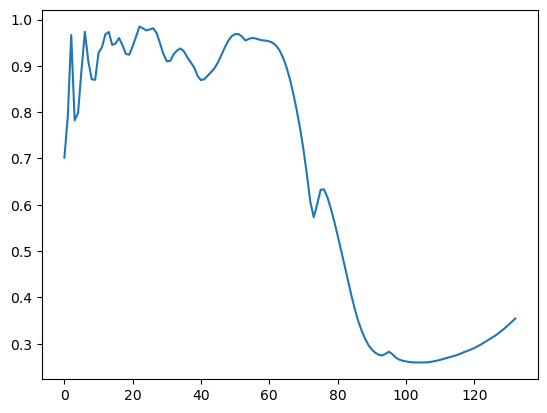

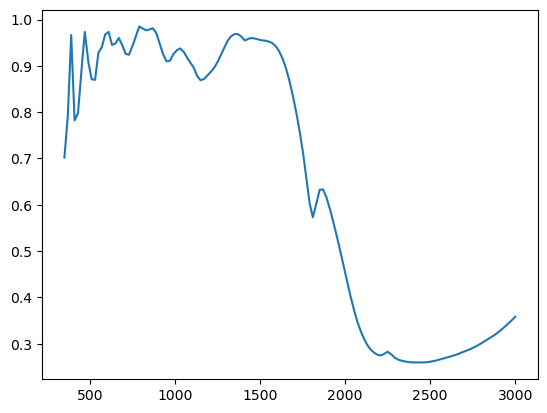

In [89]:
import numpy as np
import matplotlib.pyplot as plt
trns_ppw = list(pairs.values())
indices_used = np.array(np.round(np.array(list(pairs.keys()))*1000), dtype = int)
plt.plot(trns_ppw)
plt.show()
data = [(indices_used[i], trns_ppw[i]) for i in range(len(indices_used))]
interpolated_data = interpolate_dataset(data, extend = 10, poly_order = 1)
x_orig = [point[0] for point in interpolated_data]
y_orig = [point[1] for point in interpolated_data]
plt.plot(x_orig, y_orig, label='Interpolated Data')
plt.show()
import sys
sys.path.append('../trials/')
import ff


In [90]:
import torch
bandgaps = [.5, .6, .61, .62, .63, .64, .65, .66, .67, .68, .69, .7, .71, .72, .726, .8, .9, 1]
for bandgap in bandgaps:
    print(bandgap,ff.power_ratio(torch.tensor(x_orig)/1000, torch.tensor(y_orig), ff.T_e, bandgap).item())

0.5 0.41746868445645147
0.6 0.4507957136331669
0.61 0.45207790483870647
0.62 0.4523292728424677
0.63 0.45155035361034357
0.64 0.4497547070794239
0.65 0.4470598169734282
0.66 0.4436310287703104
0.67 0.4398083592325142
0.68 0.43633559502788555
0.69 0.4334941450484815
0.7 0.42983363199157654
0.71 0.42498158635991284
0.72 0.41918940295554635
0.726 0.4150620904042366
0.8 0.35450788667598054
0.9 0.272577299670937
1 0.20383514499713581


/tmp/ipykernel_106124/263784510.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(f'../logs/{f}/emit.pt')


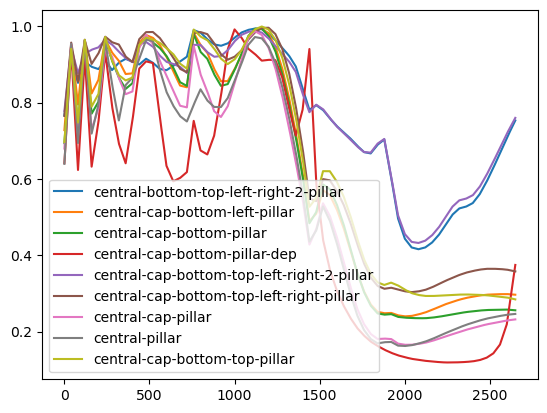

<Figure size 2000x1200 with 0 Axes>

In [19]:
strings = ['central-bottom-top-left-right-2-pillar', 'central-cap-bottom-left-pillar', 'central-cap-bottom-pillar', 'central-cap-bottom-pillar-dep', 'central-cap-bottom-top-left-right-2-pillar', 'central-cap-bottom-top-left-right-pillar', 'central-cap-pillar', 'central-pillar', 'central-cap-bottom-top-pillar']
import torch
import numpy as np
import matplotlib.pyplot as plt
for f in strings:
    tensor = torch.load(f'../logs/{f}/emit.pt')
    plt.plot(tensor.numpy(), label=f)
plt.legend()
plt.figure(figsize=(20,12));
plt.show()